# Time Series Traffic Analysis

In [62]:
%matplotlib notebook

import os
import shutil
import urllib3

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data Loading

In [63]:
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz"
PATH = "metro_interstate.csv.gz"


def fetch_data(url=URL, path=PATH):
    http = urllib3.PoolManager()
    with open(path, 'wb') as f:
        r = http.request('GET', url, preload_content=False)
        shutil.copyfileobj(r, f)
    

# Only need to run once!
fetch_data()

In [64]:
data = pd.read_csv(
    "metro_interstate.csv.gz",
    index_col="date_time",
    parse_dates=True
)
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918


<IPython.core.display.Javascript object>


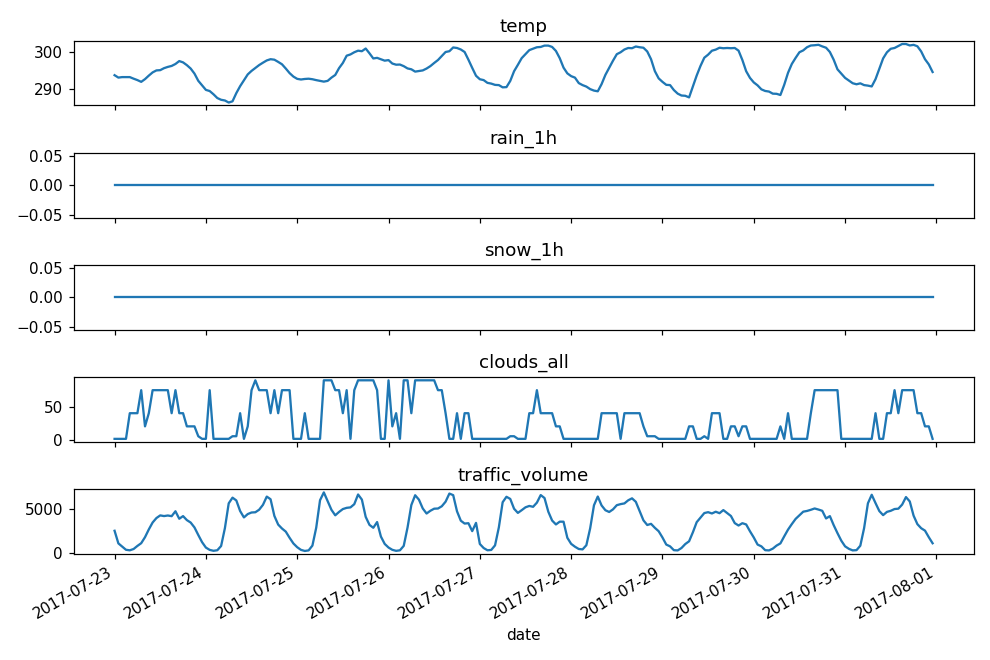

In [65]:
def plot_numeric_features(df=data, cols=["temp", "rain_1h", "snow_1h", "clouds_all", "traffic_volume"]):
    fig, axes = plt.subplots(nrows=len(cols), sharex=True, figsize=(9,6))
    
    for col, ax in zip(cols, axes):
        df[col].plot(ax=ax)
        ax.set_title(col)
        
        if ax == axes[-1]:
            ax.set_xlabel("date")
    
    fig.tight_layout()
    return ax


# Plot features in date range
_ = plot_numeric_features(data.loc["2017-07-23":"2017-07-31"])

## Simple Machine Learning

Just computing a regression on traffic volume for the numeric columns

In [32]:
cols=["temp", "rain_1h", "snow_1h", "clouds_all"]

X = data[cols]
y = data["traffic_volume"]

In [33]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)
model.fit(X, y)

LinearRegression()

In [42]:
def describe_model(model):
    print(model.get_params())
    print()
    
    for attr in dir(model):
        if attr.endswith("_") and not attr.startswith("_"):
            print(f"{attr} {getattr(model, attr)}")

            
describe_model(model)

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

coef_ [2.06411786e+01 1.36020718e-01 2.93120175e+02 4.13182143e+00]
intercept_ -2748.668826439554
n_features_in_ 4
rank_ 4
singular_ [9.83392165e+03 8.57146982e+03 2.91101785e+03 1.79225515e+00]


In [46]:
from sklearn.model_selection import train_test_split as tts 


X_train, X_test, y_train, y_test = tts(X, y, train_size=0.8)

In [47]:
lrm = LinearRegression(normalize=True).fit(X_train, y_train)
lrm.score(X_test, y_test)

0.020874192255888047

In [50]:
from sklearn.ensemble import RandomForestRegressor

rfm = RandomForestRegressor(n_estimators=10, max_depth=3).fit(X_train, y_train)
describe_model(rfm)
rfm.score(X_test, y_test)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

base_estimator_ DecisionTreeRegressor()
estimators_ [DecisionTreeRegressor(max_depth=3, max_features='auto', random_state=1445084440), DecisionTreeRegressor(max_depth=3, max_features='auto', random_state=101666231), DecisionTreeRegressor(max_depth=3, max_features='auto', random_state=144693004), DecisionTreeRegressor(max_depth=3, max_features='auto', random_state=477096132), DecisionTreeRegressor(max_depth=3, max_features='auto', random_state=1244969717), DecisionTreeRegressor(max_depth=3, max_features='auto', random_state=1850425487), DecisionTreeRegressor(max_depth=3, max_features='auto', random_

0.050436846712423655

In [57]:
data["holiday_binary"] = [0 if not holiday else 1 for holiday in data["holiday"].values]
data["hour_of_day"] = data.index.hour

In [58]:
cols=["temp", "rain_1h", "snow_1h", "clouds_all", "holiday_binary", "hour_of_day"]

X = data[cols]
y = data["traffic_volume"]
X_train, X_test, y_train, y_test = tts(X, y, train_size=0.8)

In [59]:
lrm = LinearRegression(normalize=True).fit(X_train, y_train)
lrm.score(X_test, y_test)

0.12759894256740967

In [60]:
rfm = RandomForestRegressor(n_estimators=10, max_depth=3).fit(X_train, y_train)
rfm.score(X_test, y_test)

0.7473567961865994